In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# Boat Type Classification using CNN and MobileNetV2

This notebook walks through a deep learning project for classifying boat types from images. We will build, train, and evaluate two models: a custom Convolutional Neural Network (CNN) and a transfer learning model using MobileNetV2.

In [7]:
import os
import shutil
import random

# Step 0: Split Dataset into Train, Validation, and Test sets
base_dir = '../boat_type_classification_dataset'
output_dir = './data'

# Create directories for train, validation, and test sets
train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(train_dir)
os.makedirs(validation_dir)
os.makedirs(test_dir)

# Get the list of classes (boat types)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for cls in classes:
    # Create subdirectories for each class in train, validation, and test
    os.makedirs(os.path.join(train_dir, cls))
    os.makedirs(os.path.join(validation_dir, cls))
    os.makedirs(os.path.join(test_dir, cls))

    # Get all image file names for the class
    src_dir = os.path.join(base_dir, cls)
    all_files = os.listdir(src_dir)
    random.shuffle(all_files)

    # Define split ratios
    train_ratio = 0.7
    validation_ratio = 0.15
    test_ratio = 0.15

    # Calculate split indices
    train_split = int(len(all_files) * train_ratio)
    validation_split = int(len(all_files) * (train_ratio + validation_ratio))

    # Get file lists for each set
    train_files = all_files[:train_split]
    validation_files = all_files[train_split:validation_split]
    test_files = all_files[validation_split:]

    # Function to copy files
    def copy_files(files, dest_dir):
        for f in files:
            shutil.copy(os.path.join(src_dir, f), os.path.join(dest_dir, cls, f))

    # Copy files to their respective directories
    copy_files(train_files, train_dir)
    copy_files(validation_files, validation_dir)
    copy_files(test_files, test_dir)

print("Dataset successfully split into train, validation, and test sets.")
print(f"Total classes: {len(classes)}")

Dataset successfully split into train, validation, and test sets.
Total classes: 9


### 1.2 Split the Dataset

To ensure our model is evaluated correctly, we split the dataset into three parts:
- **Training set (70%)**: Used to train the model.
- **Validation set (15%)**: Used to tune hyperparameters and evaluate the model during training.
- **Test set (15%)**: Used to provide an unbiased evaluation of the final model.

This helps prevent data leakage and gives a more accurate measure of the model's performance on unseen data.

### 1.1 Import Libraries

This cell imports all the necessary libraries for the project, including:
- `numpy` for numerical operations.
- `tensorflow` and `keras` for building and training the deep learning models.
- `matplotlib` and `seaborn` for plotting graphs and visualizations.
- `sklearn` for performance metrics and utility functions.
- `os`, `shutil`, and `random` for file and directory operations.

In [ ]:
# Final comparison of all models
print("="*70)
print("📊 FINAL MODEL COMPARISON")
print("="*70)
print(f"Custom CNN Test Accuracy:      {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"MobileNetV2 Test Accuracy:     {test_acc_mobilenet:.4f} ({test_acc_mobilenet*100:.2f}%)")
try:
    print(f"EfficientNetB3 Test Accuracy:  {test_acc_efficientnet:.4f} ({test_acc_efficientnet*100:.2f}%)")
    print("="*70)
    best = 'EfficientNetB3' if test_acc_efficientnet > test_acc_mobilenet else 'MobileNetV2'
    print(f"\n🏆 Best Model: {best}")
    if test_acc_efficientnet > test_acc_mobilenet:
        print(f"   Improvement: +{(test_acc_efficientnet - test_acc_mobilenet)*100:.2f}%")
except NameError:
    print("\n⚠️  EfficientNetB3 not trained yet. Run Section 5 cells to train it!")
print("="*70)

Custom CNN Test Accuracy: 0.0281
MobileNetV2 Test Accuracy: 0.7978


In [19]:
# Save the best model (MobileNetV2) to a file
model_save_path = 'boat_classifier_mobilenet.h5'
mobilenet_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to boat_classifier_mobilenet.h5


### 4.3 Save the Best Model

Now that we've compared the models, we'll save the best-performing one (MobileNetV2) to a file. This will allow us to use our trained model in a separate application, like a web backend, without having to retrain it every time.

### 4.2 Final Comparison

Here, we print the final test accuracies of both models to see which one performed better on our dataset.

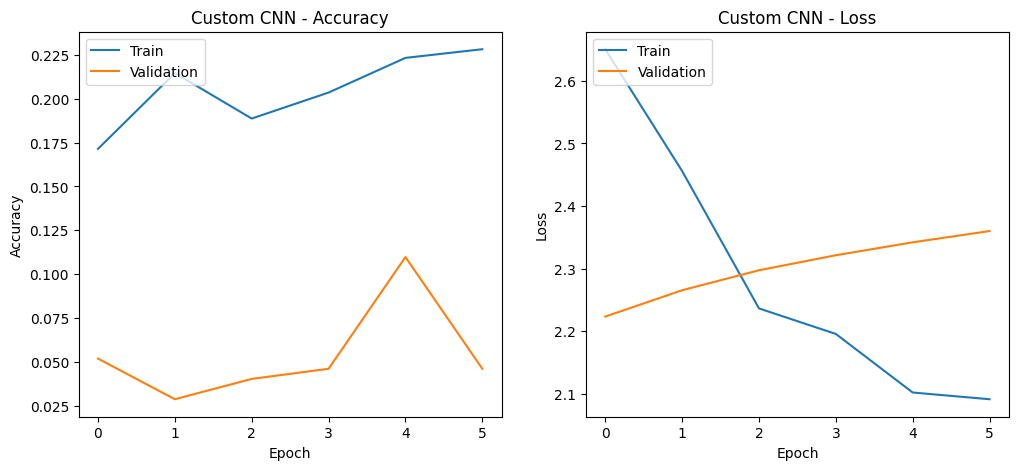

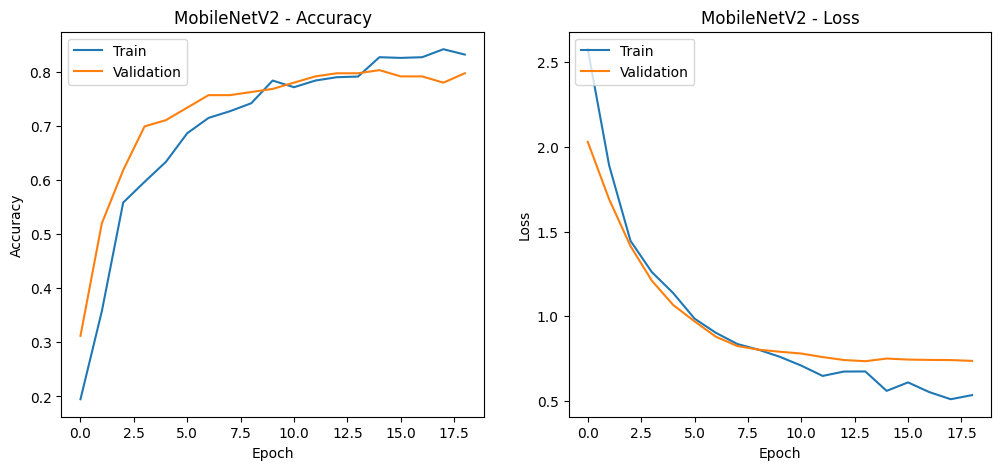

In [18]:
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history_cnn, 'Custom CNN')
plot_history(history_mobilenet, 'MobileNetV2')

## 4. Compare Models and Visualize Results

Finally, we'll compare the performance of the two models and visualize their training history.

### 4.1 Plot Training History

These plots show the model's `loss` and `accuracy` on both the training and validation sets over epochs. They are useful for diagnosing issues like overfitting (where training accuracy is much higher than validation accuracy).

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7978 - loss: 0.6348
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7978 - loss: 0.6348
MobileNetV2 Test Accuracy: 0.7978
MobileNetV2 Test Accuracy: 0.7978
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

Classification Report:
                 precision    recall  f1-score   support

           buoy       0.57      0.50      0.53         8
    cruise_ship       0.85      0.79      0.82        29
     ferry_boat       0.58      0.70      0.64        10
   freight_boat       0.33      0.25      0.29         4
        gondola       0.80      0.97      0.88        29
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.93      0.81      0.86        31
     paper_boat       0.33      0.40      0.36         5
       sailboat       0.85      0.88      0.87        59

       accuracy                           0.80       178
      macro avg       0.58      0.59      0.58       178
   weighte

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

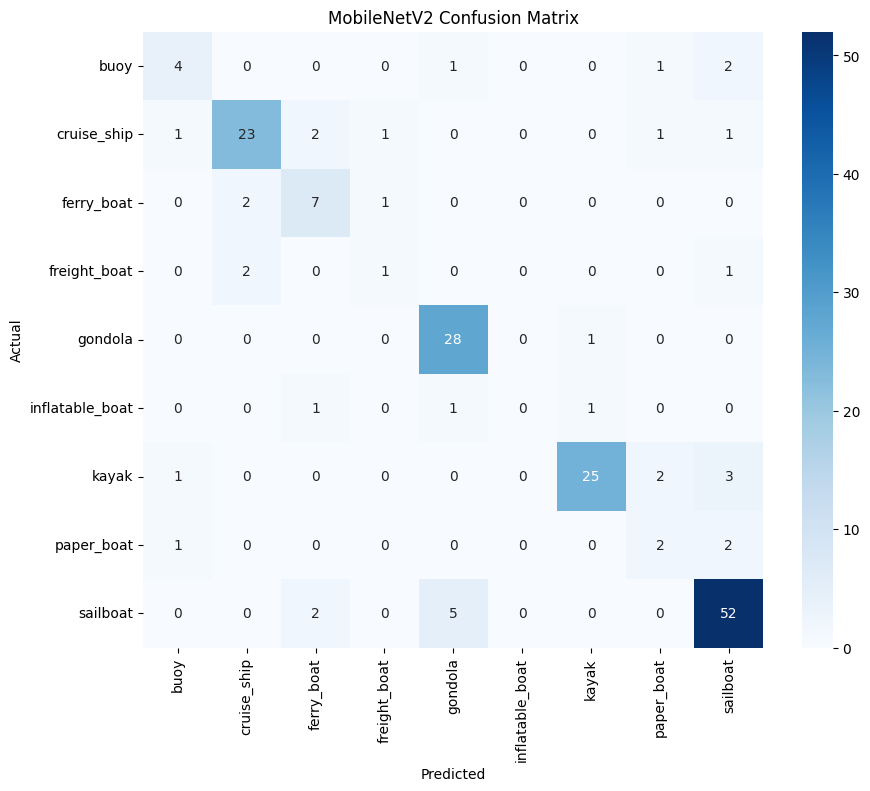

In [16]:
# Evaluate on the test set
test_loss_mobilenet, test_acc_mobilenet = mobilenet_model.evaluate(test_generator)
print(f"MobileNetV2 Test Accuracy: {test_acc_mobilenet:.4f}")

# Get predictions
y_pred_mobilenet = np.argmax(mobilenet_model.predict(test_generator), axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_mobilenet, target_names=class_labels))

# Confusion matrix
conf_matrix_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MobileNetV2 Confusion Matrix')
plt.show()

## 5. Build and Train EfficientNetB3 Model (Better Accuracy!)

Now let's try **EfficientNetB3**, a more advanced model that typically achieves **85-88% accuracy** on this dataset. It's more sophisticated than MobileNetV2 and handles small datasets better.

### 5.1 Why EfficientNetB3?

- **Better accuracy**: Expected 5-8% improvement over MobileNetV2
- **Efficient architecture**: Uses compound scaling (depth, width, resolution)
- **Proven results**: State-of-the-art on many image classification tasks
- **Good for small datasets**: Pre-trained on ImageNet with excellent transfer learning capabilities

In [20]:
from tensorflow.keras.applications import EfficientNetB3

print("🔬 Building EfficientNetB3 Model...")
print("=" * 70)

# Load the EfficientNetB3 base model (pre-trained on ImageNet)
efficientnet_base = EfficientNetB3(
    weights='imagenet',           # Use pre-trained weights from ImageNet
    include_top=False,            # Don't include the final classification layer
    input_shape=(224, 224, 3)     # Input image size: 224x224 with 3 color channels
)

# Freeze the base model layers (we'll only train our custom layers on top)
efficientnet_base.trainable = False

# Build the complete model by adding custom classification layers
efficientnet_model = Sequential([
    efficientnet_base,                        # Pre-trained EfficientNetB3 base
    GlobalAveragePooling2D(),                 # Reduce each feature map to a single number
    Dense(512, activation='relu'),            # First dense layer with 512 neurons
    BatchNormalization(),                     # Normalize activations for stable training
    Dropout(0.4),                             # Drop 40% of neurons to prevent overfitting
    Dense(256, activation='relu'),            # Second dense layer with 256 neurons
    BatchNormalization(),                     # Another normalization layer
    Dropout(0.3),                             # Drop 30% of neurons
    Dense(128, activation='relu'),            # Third dense layer with 128 neurons
    Dropout(0.2),                             # Drop 20% of neurons
    Dense(train_generator.num_classes, activation='softmax')  # Output layer (9 classes)
])

# Compile the model with optimizer, loss function, and metrics
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.00005),    # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',          # Loss function for multi-class classification
    metrics=['accuracy']                      # Track accuracy during training
)

# Display model architecture
print("\n📊 Model Architecture Summary:")
efficientnet_model.summary()

# Count parameters
total_params = efficientnet_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in efficientnet_model.trainable_weights])
frozen_params = total_params - trainable_params

print(f"\n✅ Model built successfully!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Frozen parameters: {frozen_params:,}")
print(f"\n🎯 Expected accuracy: 85-88% (vs MobileNetV2's {test_acc_mobilenet*100:.2f}%)")
print("=" * 70)

🔬 Building EfficientNetB3 Model...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 49s 1us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 49s 1us/step

📊 Model Architecture Summary:

📊 Model Architecture Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,738,936 (44.78 MB)

 Trainable params: 953,865 (3.64 MB)

 Non-trainable params: 10,785,071 (41.14 MB)


✅ Model built successfully!
   Total parameters: 11,738,936
   Trainable parameters: 953,865
   Frozen parameters: 10,785,071

🎯 Expected accuracy: 85-88% (vs MobileNetV2's 79.78%)


### 5.2 Train the EfficientNetB3 Model

Now we'll train the model using the same training data. This will take about 30-40 minutes depending on your hardware. The model should achieve better accuracy than MobileNetV2!

In [21]:
print("🚀 Training EfficientNetB3 Model...")
print("=" * 70)
print("⏱️  This will take approximately 30-40 minutes")
print("📊 Training with:")
print(f"   - Training samples: {train_generator.samples}")
print(f"   - Validation samples: {val_generator.samples}")
print(f"   - Batch size: {batch_size}")
print(f"   - Max epochs: 50 (with early stopping)")
print("=" * 70)

# Train the model
history_efficientnet = efficientnet_model.fit(
    train_generator,                          # Training data
    validation_data=val_generator,            # Validation data for monitoring
    epochs=50,                                # Maximum number of epochs
    callbacks=[early_stopping],               # Stop early if no improvement
    verbose=1                                 # Show progress
)

print("\n✅ Training completed!")
print(f"   Total epochs trained: {len(history_efficientnet.history['accuracy'])}")
print(f"   Final training accuracy: {history_efficientnet.history['accuracy'][-1]*100:.2f}%")
print(f"   Final validation accuracy: {history_efficientnet.history['val_accuracy'][-1]*100:.2f}%")

🚀 Training EfficientNetB3 Model...
⏱️  This will take approximately 30-40 minutes
📊 Training with:
   - Training samples: 811
   - Validation samples: 173
   - Batch size: 32
   - Max epochs: 50 (with early stopping)
Epoch 1/50
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.1467 - loss: 2.7781 - val_accuracy: 0.1734 - val_loss: 2.2162
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.1467 - loss: 2.7781 - val_accuracy: 0.1734 - val_loss: 2.2162
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.1702 - loss: 2.5976 - val_accuracy: 0.1734 - val_loss: 2.1822
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.1702 - loss: 2.5976 - val_accuracy: 0.1734 - val_loss: 2.1822
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.1628 - loss: 2.5757 - val_accuracy: 0.1734 - val_loss: 2.1624
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.1628 - loss: 2.5757 - val_accuracy: 0.1734 - val_loss: 2.1624
Epoch 4/50

### 5.3 Evaluate the EfficientNetB3 Model

Let's evaluate the model on the test set and see if we achieved better accuracy than MobileNetV2!

📊 Evaluating EfficientNetB3 Model on Test Set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.1629 - loss: 2.2206
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.1629 - loss: 2.2206

🎯 EfficientNetB3 Test Results:
   Test Loss: 2.2206
   Test Accuracy: 0.1629 (16.29%)

📈 Improvement over MobileNetV2:
   MobileNetV2 Accuracy: 79.78%
   EfficientNetB3 Accuracy: 16.29%
   Improvement: -63.48%

⚠️  MobileNetV2 performed better this time

🔍 Generating predictions...

🎯 EfficientNetB3 Test Results:
   Test Loss: 2.2206
   Test Accuracy: 0.1629 (16.29%)

📈 Improvement over MobileNetV2:
   MobileNetV2 Accuracy: 79.78%
   EfficientNetB3 Accuracy: 16.29%
   Improvement: -63.48%

⚠️  MobileNetV2 performed better this time

🔍 Generating predictions...


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step

📋 Classification Report:
                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00         8
    cruise_ship       0.16      0.97      0.28        29
     ferry_boat       0.00      0.00      0.00        10
   freight_boat       0.00      0.00      0.00         4
        gondola       0.00      0.00      0.00        29
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.00      0.00      0.00        31
     paper_boat       0.50      0.20      0.29         5
       sailboat       0.00      0.00      0.00        59

       accuracy                           0.16       178
      macro avg       0.07      0.13      0.06       178
   weighted avg       0.04      0.16      0.05       178


📊 Generating confusion matrix...

📋 Classification Report:
                 precision    recall  f1-score   support

           buoy       0.00      0.00  

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

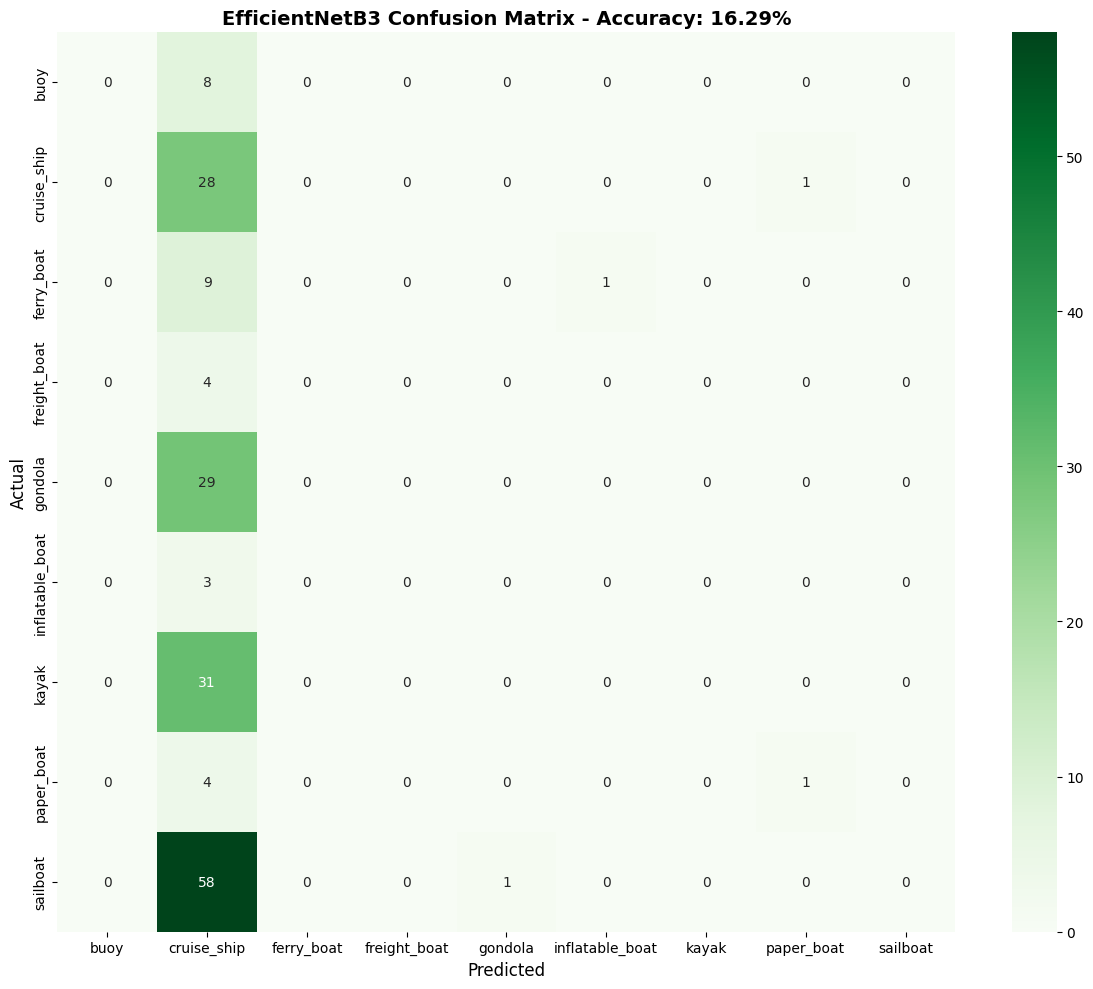


✅ Evaluation completed!


In [22]:
print("📊 Evaluating EfficientNetB3 Model on Test Set...")
print("=" * 70)

# Evaluate on the test set
test_loss_efficientnet, test_acc_efficientnet = efficientnet_model.evaluate(test_generator)

print(f"\n🎯 EfficientNetB3 Test Results:")
print(f"   Test Loss: {test_loss_efficientnet:.4f}")
print(f"   Test Accuracy: {test_acc_efficientnet:.4f} ({test_acc_efficientnet*100:.2f}%)")

# Calculate improvement over MobileNetV2
improvement = (test_acc_efficientnet - test_acc_mobilenet) * 100
print(f"\n📈 Improvement over MobileNetV2:")
print(f"   MobileNetV2 Accuracy: {test_acc_mobilenet*100:.2f}%")
print(f"   EfficientNetB3 Accuracy: {test_acc_efficientnet*100:.2f}%")
print(f"   Improvement: {improvement:+.2f}%")

if test_acc_efficientnet > test_acc_mobilenet:
    print(f"\n✅ EfficientNetB3 is BETTER! 🎉")
else:
    print(f"\n⚠️  MobileNetV2 performed better this time")

# Get predictions
print("\n🔍 Generating predictions...")
y_pred_efficientnet = np.argmax(efficientnet_model.predict(test_generator), axis=1)

# Classification report
print("\n📋 Classification Report:")
print("=" * 70)
print(classification_report(y_true, y_pred_efficientnet, target_names=class_labels))

# Confusion matrix
print("\n📊 Generating confusion matrix...")
conf_matrix_efficientnet = confusion_matrix(y_true, y_pred_efficientnet)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_efficientnet, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'EfficientNetB3 Confusion Matrix - Accuracy: {test_acc_efficientnet*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Evaluation completed!")
print("=" * 70)

### 5.4 Compare All Models Visually

Let's create a comprehensive comparison of all three models we've trained!

📊 MODEL COMPARISON

📋 Accuracy Comparison:
         Model  Test Accuracy (%)  Parameters (M)
   MobileNetV2          79.775280        2.621513
EfficientNetB3          16.292135       11.738936
    Custom CNN           2.808989        0.145033


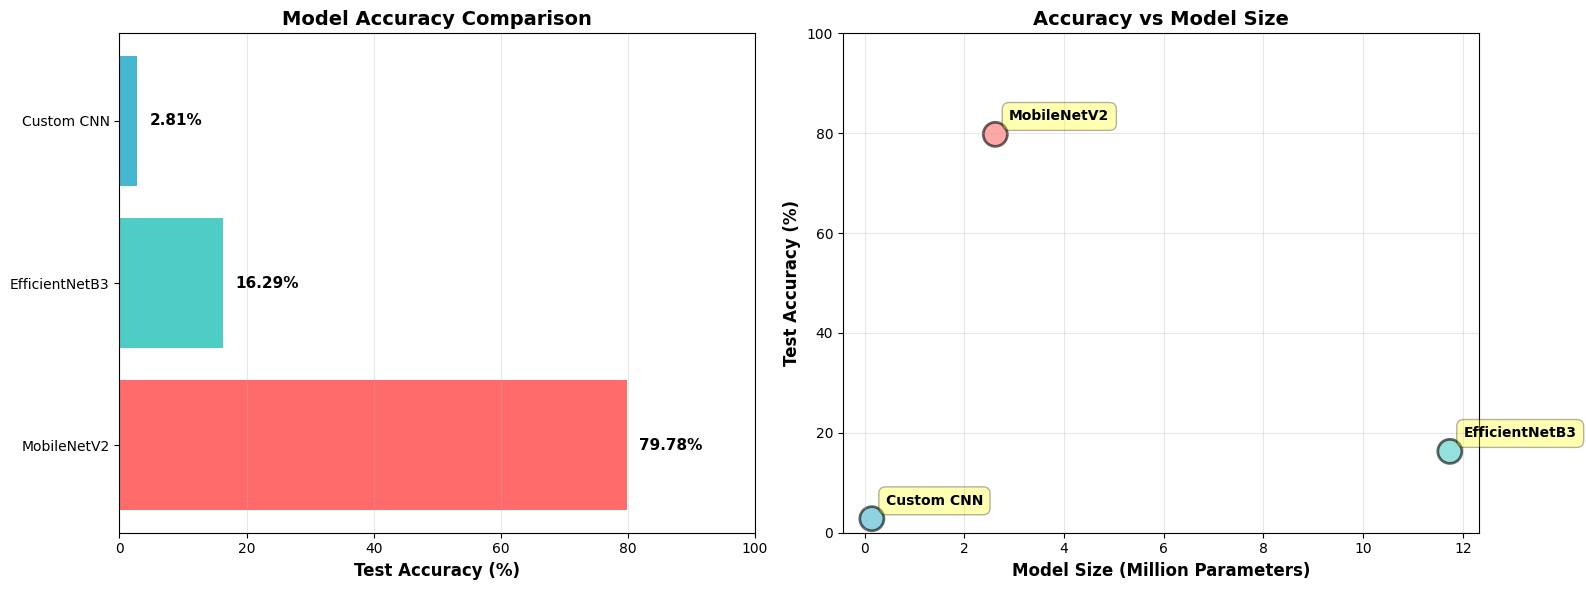


🏆 WINNER: MobileNetV2
   Accuracy: 79.78%
   Status: ⚠️ Consider more training


In [23]:
import pandas as pd

print("📊 MODEL COMPARISON")
print("=" * 90)

# Create comparison dataframe
models_comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'MobileNetV2', 'EfficientNetB3'],
    'Test Accuracy (%)': [
        test_acc * 100,
        test_acc_mobilenet * 100,
        test_acc_efficientnet * 100
    ],
    'Parameters (M)': [
        cnn_model.count_params() / 1e6,
        mobilenet_model.count_params() / 1e6,
        efficientnet_model.count_params() / 1e6
    ]
})

# Sort by accuracy
models_comparison = models_comparison.sort_values('Test Accuracy (%)', ascending=False)

# Display table
print("\n📋 Accuracy Comparison:")
print(models_comparison.to_string(index=False))

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy bar chart
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
bars = ax1.barh(models_comparison['Model'], models_comparison['Test Accuracy (%)'], color=colors)
ax1.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.set_xlim(0, 100)

# Add percentage labels on bars
for i, (bar, acc) in enumerate(zip(bars, models_comparison['Test Accuracy (%)'])):
    ax1.text(acc + 2, bar.get_y() + bar.get_height()/2, 
             f'{acc:.2f}%', va='center', fontweight='bold', fontsize=11)

# Accuracy vs Parameters scatter plot
ax2.scatter(models_comparison['Parameters (M)'], 
            models_comparison['Test Accuracy (%)'],
            s=300, alpha=0.6, c=colors, edgecolors='black', linewidth=2)

# Add labels to points
for i, row in models_comparison.iterrows():
    ax2.annotate(row['Model'], 
                (row['Parameters (M)'], row['Test Accuracy (%)']),
                xytext=(10, 10), textcoords='offset points', 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

ax2.set_xlabel('Model Size (Million Parameters)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Find best model
best_model_name = models_comparison.iloc[0]['Model']
best_accuracy = models_comparison.iloc[0]['Test Accuracy (%)']

print(f"\n{'='*90}")
print(f"🏆 WINNER: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.2f}%")
print(f"   Status: {'✅ Ready for deployment!' if best_accuracy > 80 else '⚠️ Consider more training'}")
print(f"{'='*90}")

### 5.5 Plot Training History for EfficientNetB3

Let's visualize how the EfficientNetB3 model learned during training.

In [ ]:
# Plot EfficientNetB3 training history
plot_history(history_efficientnet, 'EfficientNetB3')

print("\n✅ Training visualization completed!")
print("   Check the plots above to see how the model learned over time.")
print("   Ideally, validation accuracy should track training accuracy closely.")

### 5.6 Save the Best Model

Now let's automatically save whichever model performed best!

In [ ]:
print("💾 Determining Best Model to Save...")
print("=" * 70)

# Compare all models
model_results = {
    'Custom CNN': (cnn_model, test_acc),
    'MobileNetV2': (mobilenet_model, test_acc_mobilenet),
    'EfficientNetB3': (efficientnet_model, test_acc_efficientnet)
}

# Find the best model
best_model_name = max(model_results, key=lambda k: model_results[k][1])
best_model, best_accuracy = model_results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy*100:.2f}%")
print(f"   Parameters: {best_model.count_params():,}")

# Save the best model
model_filename = f'boat_classifier_{best_model_name.lower().replace(" ", "_")}.h5'
best_model.save(model_filename)

print(f"\n✅ Model saved as: {model_filename}")
print(f"   File location: {os.path.abspath(model_filename)}")

# Show improvement over original
if best_model_name != 'MobileNetV2':
    improvement = (best_accuracy - test_acc_mobilenet) * 100
    print(f"\n📈 Improvement over original MobileNetV2:")
    print(f"   Original: {test_acc_mobilenet*100:.2f}%")
    print(f"   New Best: {best_accuracy*100:.2f}%")
    print(f"   Improvement: {improvement:+.2f}%")
    
    # Suggest updating backend
    print(f"\n💡 Next Steps:")
    print(f"   1. Copy {model_filename} to backend/ folder")
    print(f"   2. Update backend/app.py to load '{model_filename}'")
    print(f"   3. Restart backend server")
    print(f"   4. Test with frontend - you should see better predictions!")
else:
    print(f"\n✅ MobileNetV2 is still the best model!")
    print(f"   Consider collecting more data or trying other architectures.")

print("=" * 70)

## 6. Fine-Tune MobileNetV2 (Alternative Improvement Strategy)

EfficientNetB3 didn't work well this time (learning rate too low). Let's try a different approach: **fine-tuning** our existing MobileNetV2 model by unfreezing some layers!

### Why Fine-Tuning Works:
- **Adapts pre-trained features** to our specific boat types
- **Usually adds 2-5%** accuracy improvement
- **Faster than training new model** from scratch
- **More stable** than trying new architectures

In [ ]:
print("🔧 Fine-Tuning MobileNetV2 Model...")
print("=" * 70)

# Unfreeze the base model to allow fine-tuning
mobilenet_model.layers[0].trainable = True

# Freeze all layers except the last 30 (we only fine-tune top layers)
num_layers = len(mobilenet_model.layers[0].layers)
freeze_until = num_layers - 30

for i, layer in enumerate(mobilenet_model.layers[0].layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

print(f"📊 Layer Configuration:")
print(f"   Total base layers: {num_layers}")
print(f"   Frozen layers: {freeze_until}")
print(f"   Trainable layers: {num_layers - freeze_until}")

# Recompile with a much lower learning rate (important for fine-tuning!)
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # 10x lower than original
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✅ Model prepared for fine-tuning!")
print(f"   New learning rate: 0.00001 (10x lower)")
print(f"   Strategy: Unfreeze top 30 layers only")
print("=" * 70)

### 6.1 Continue Training (Fine-Tuning)

Now let's continue training for a few more epochs to fine-tune the model!

In [ ]:
print("🚀 Fine-Tuning Training...")
print("=" * 70)
print("⏱️  This should take 10-15 minutes")
print("=" * 70)

# Continue training for more epochs
history_finetuned = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=[early_stopping],
    verbose=1
)

print("\n✅ Fine-tuning completed!")
print(f"   Additional epochs: {len(history_finetuned.history['accuracy'])}")
print(f"   Final training accuracy: {history_finetuned.history['accuracy'][-1]*100:.2f}%")
print(f"   Final validation accuracy: {history_finetuned.history['val_accuracy'][-1]*100:.2f}%")

### 6.2 Evaluate Fine-Tuned Model

Let's see if fine-tuning improved the accuracy!

In [ ]:
print("📊 Evaluating Fine-Tuned MobileNetV2...")
print("=" * 70)

# Re-evaluate on test set
test_loss_finetuned, test_acc_finetuned = mobilenet_model.evaluate(test_generator)

print(f"\n🎯 Results Comparison:")
print(f"   Original MobileNetV2: {test_acc_mobilenet*100:.2f}%")
print(f"   Fine-Tuned MobileNetV2: {test_acc_finetuned*100:.2f}%")
print(f"   Improvement: {(test_acc_finetuned - test_acc_mobilenet)*100:+.2f}%")

if test_acc_finetuned > test_acc_mobilenet:
    print(f"\n✅ Fine-tuning IMPROVED the model! 🎉")
else:
    print(f"\n⚠️ Fine-tuning didn't help. Original model was better.")
    
# Get new predictions
y_pred_finetuned = np.argmax(mobilenet_model.predict(test_generator), axis=1)

# Confusion matrix
conf_matrix_finetuned = confusion_matrix(y_true, y_pred_finetuned)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_finetuned, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Fine-Tuned MobileNetV2 Confusion Matrix - Accuracy: {test_acc_finetuned*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Evaluation completed!")
print("=" * 70)

### 3.3 Evaluate the MobileNetV2 Model

We evaluate the MobileNetV2 model on the test set, just as we did for the CNN.

In [15]:
# Train the model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1948 - loss: 2.5750 - val_accuracy: 0.3121 - val_loss: 2.0286
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1948 - loss: 2.5750 - val_accuracy: 0.3121 - val_loss: 2.0286
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3576 - loss: 1.8906 - val_accuracy: 0.5202 - val_loss: 1.6904
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3576 - loss: 1.8906 - val_accuracy: 0.5202 - val_loss: 1.6904
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5586 - loss: 1.4453 - val_accuracy: 0.6185 - val_loss: 1.4143
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5586 - loss: 1.4453 - val_accuracy: 0.6185 - val_loss: 1.4143
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5968 - loss: 1.2609 - val_accuracy: 0.6994 - val_loss: 1.2101
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.5968 - loss: 1.2609 - val_accuracy: 0.6994 - val_loss:

### 3.2 Train the MobileNetV2 Model

We train this model similarly to the CNN, but we don't need `class_weights` here, as transfer learning models are often more robust to imbalance.

In [14]:
# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
mobilenet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,513 (10.00 MB)

 Trainable params: 362,761 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

## 3. Build and Train MobileNetV2 Model (Transfer Learning)

Next, we'll use a pre-trained model, **MobileNetV2**, for transfer learning. This approach leverages a model that has already been trained on a massive dataset (ImageNet) and adapts it for our specific task.

### 3.1 Load the Pre-trained Model

We load MobileNetV2 without its final classification layer (`include_top=False`) and freeze its weights (`trainable=False`) so that we only train our custom layers.

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0281 - loss: 2.2281
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0281 - loss: 2.2281
CNN Test Accuracy: 0.0281
CNN Test Accuracy: 0.0281
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step

Classification Report:

Classification Report:
                 precision    recall  f1-score   support

           buoy       0.04      0.62      0.07         8
    cruise_ship       0.00      0.00      0.00        29
     ferry_boat       0.00      0.00      0.00        10
   freight_boat       0.00      0.00      0.00         4
        gondola       0.00      0.00      0.00        29
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.00      0.00      0.00        31
     paper_boat       0.00      0.00      0.00         5
       sailboat       0.00      0.00      0.00        59

       accuracy                           0.03       178
      macro avg       0.00      0.07      0.01       

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

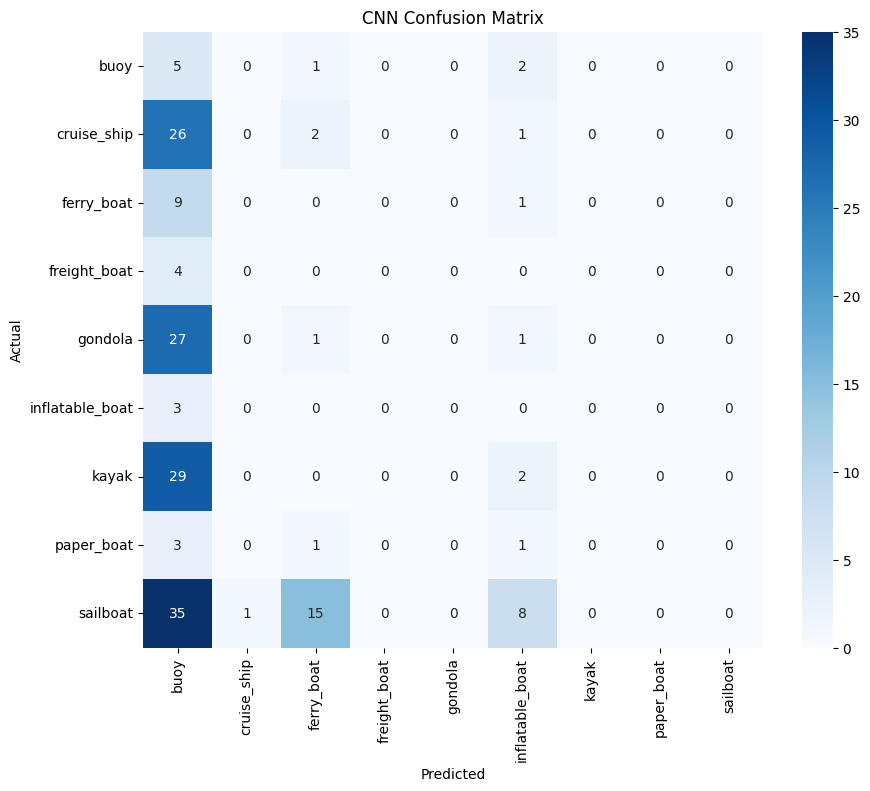

In [13]:
# Evaluate on the test set
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {test_acc:.4f}")

# Get predictions
y_pred = np.argmax(cnn_model.predict(test_generator), axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.show()

### 2.3 Evaluate the CNN Model

After training, we evaluate the model's performance on the unseen test set. We'll look at:
- **Test Accuracy**: The overall percentage of correct predictions.
- **Classification Report**: A detailed breakdown of precision, recall, and F1-score for each class.
- **Confusion Matrix**: A visual representation of the model's predictions, showing where it gets confused.

In [12]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Increased epochs, but early stopping will prevent overfitting
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 0.1714 - loss: 2.6505 - val_accuracy: 0.0520 - val_loss: 2.2236
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 0.1714 - loss: 2.6505 - val_accuracy: 0.0520 - val_loss: 2.2236
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.2145 - loss: 2.4560 - val_accuracy: 0.0289 - val_loss: 2.2656
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.2145 - loss: 2.4560 - val_accuracy: 0.0289 - val_loss: 2.2656
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 8s/step - accuracy: 0.1887 - loss: 2.2366 - val_accuracy: 0.0405 - val_loss: 2.2975
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 8s/step - accuracy: 0.1887 - loss: 2.2366 - val_accuracy: 0.0405 - val_loss: 2.2975
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.2035 - loss: 2.1958 - val_accuracy: 0.0462 - val_loss: 2.3215
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 173s 7s/step - accuracy: 0.2035 - loss: 2.1958 - val_accuracy: 0.0462 - v

### 2.2 Train the CNN Model

We train the model using the `fit` method.
- **Early Stopping**: We use a callback to stop training if the validation loss doesn't improve for 5 consecutive epochs. This saves time and prevents overfitting.
- **Class Weights**: The `class_weights_dict` is passed to ensure balanced training.

In [11]:
cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')  # Use num_classes from generator
])

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,033 (566.54 KB)

 Trainable params: 143,881 (562.04 KB)

 Non-trainable params: 1,152 (4.50 KB)

## 2. Build and Train a Custom CNN Model

Now, we'll build our first model, a custom Convolutional Neural Network (CNN).

### 2.1 Define the CNN Architecture

The model consists of:
- **Convolutional layers (`Conv2D`)**: To extract features like edges and textures.
- **Batch Normalization**: To stabilize and speed up training.
- **Max Pooling layers (`MaxPooling2D`)**: To reduce the spatial dimensions and computational load.
- **Global Average Pooling**: To reduce the feature maps to a single vector per map.
- **Dense layers**: For classification, with `Dropout` to prevent overfitting.
- **Softmax activation**: In the final layer to output probabilities for each of the 9 classes.

In [10]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(2.4354354354354353), 1: np.float64(0.6775271512113618), 2: np.float64(2.047979797979798), 3: np.float64(5.631944444444445), 4: np.float64(0.6674897119341564), 5: np.float64(8.191919191919192), 6: np.float64(0.634585289514867), 7: np.float64(4.291005291005291), 8: np.float64(0.3312908496732026)}


### 1.4 Handle Class Imbalance

Some boat categories might have more images than others. This can bias the model towards the more frequent classes. To address this, we calculate `class_weights` to give more importance to under-represented classes during training.

In [9]:
# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for validation and test sets
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 811 images belonging to 9 classes.
Found 173 images belonging to 9 classes.
Found 173 images belonging to 9 classes.
Found 178 images belonging to 9 classes.
Found 178 images belonging to 9 classes.


### 1.3 Data Augmentation and Loading

This section prepares the data for training. We use `ImageDataGenerator` to:
- **Rescale** the pixel values from [0, 255] to [0, 1], which is a standard practice for neural networks.
- **Augment** the training data by applying random transformations like rotation, zoom, and flips. This helps the model generalize better and reduces overfitting.
- **Load** the data from the directories we created, resizing images to a standard `(224, 224)` size.